# House Prices
## 4. Regularized Linear Models
[캐글]: https://www.kaggle.com/c/house-prices-advanced-regression-techniques <br>
[참고 커널모음] :https://subinium.github.io/kaggle-tutorial/house-prices <br>
해당 커널 필사 시작일 : 2020-12-23

#### Python Tutorials
아래 튜토리얼 하나씩 필사할 예정

> * 1. Comprehensive Data Exploration with Python (필사 시작일 : 2020-09-01)
https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

> * 2. House Prices EDA (필사 시작일 : 2020-09-04) (마무리한 날짜: 2020-10-25)
https://www.kaggle.com/dgawlik/house-prices-eda

> * 3. A Study on Regression Applied to the Ames Dataset (필사 시작일 :2020-11-15)
https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

> * 4. Regularized Linear Models
https://www.kaggle.com/apapiu/regularized-linear-models

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train.shape

(1460, 81)

In [5]:
test.shape

(1459, 80)

In [6]:
# train-set, test-set을 합침
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

---------------------------------------------
## Data preprocessing
여기서는 특별한 것들은 하지 않을것임.

* feature에 로그를 취함으로써, skewed한 수치형 데이터를 normal하게 만들기
* 범주형 변수는 더미변수만들기.
* 수치형 데이터의 결측치는 평균값으로 대체

#### 방법
* train set, test set을 하나의 데이터로 합쳐서 데이터 변환을 해주고나서 다시 분리시켜줌.

**1. 로그변환**
* SalePrice에 로그를 취해주고
* 수치형 변수 중 왜도가 0.75보다 큰 변수도 로그취해줌

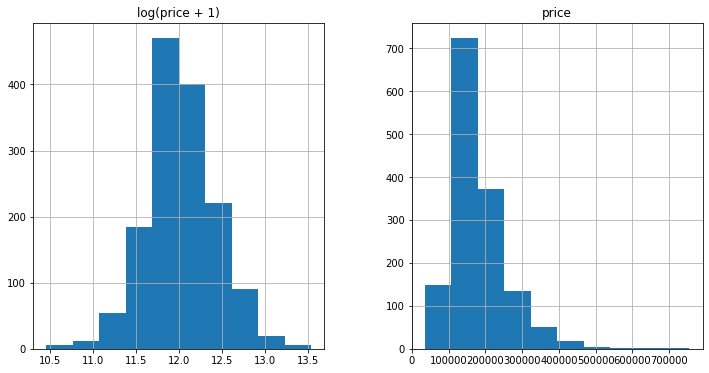

In [7]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist();

In [8]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# 수치형 데이터들의 왜도
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

# 왜도가 0.75보다큰 데이터는 로그변환
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [9]:
skewed_feats

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [10]:
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,4.110874,RL,4.189655,9.042040,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.0,0.0,NaN,NaN,NaN,0.0,2,2008,WD,Normal
1,3.044522,RL,4.394449,9.169623,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0.0,0.0,NaN,NaN,NaN,0.0,5,2007,WD,Normal
2,4.110874,RL,4.234107,9.328212,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0.0,0.0,NaN,NaN,NaN,0.0,9,2008,WD,Normal
3,4.262680,RL,4.110874,9.164401,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0.0,0.0,NaN,NaN,NaN,0.0,2,2006,WD,Abnorml
4,4.110874,RL,4.442651,9.565284,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0.0,0.0,NaN,NaN,NaN,0.0,12,2008,WD,Normal


**2. 더미변수**

In [11]:
all_data=pd.get_dummies(all_data)

**3. 컬럼의 평균값으로 결측치 채우기**

In [12]:
all_data=all_data.fillna(all_data.mean())

**4. 모델링을 위한 train,test데이터분할**

In [13]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

------------------------------------------------------
## Models
* L1 (Lasso), L2(Ridge) regularization을 모두 사용해볼것이다.
* 모델을 평가하고 최고의 tuning파라미터를 선택하기위해 교차검증 rmse 를 도출하는 함수를 정의할것이다.

### (1) Ridge Model
* 릿지모델에서 메인 튜닝 파라미터는 alpha값. 모델이 얼마나 유연한지를 측정하는 규제 파라미터이다. 
* 규제가 강할수록 모델이 overfit될 가능성이 적다.
    * alpha의 default값은 1이고, 높을수록 Regularization을 강화하여 계수를 0에 가깝게 만듬.
* 하지만, 동시에 유연성을 잃을수있고, 데이터의 모든 signal을 발견하기 어려울수있다.

In [14]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

# 회귀 문제에서 scoring은 neg_mean_squared_error를 사용했지만, 분류문제에서는 accuracy사용.
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [15]:
model_ridge=Ridge()

In [16]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

In [17]:
# alphas개수 11개, 결과도 11개
cv_ridge

[0.13893637694024513,
 0.13777538277187878,
 0.13501433618086014,
 0.13136184989399582,
 0.12864892446111878,
 0.12782179689257286,
 0.12733734668670774,
 0.12752940439753804,
 0.12895888148450046,
 0.13099437857191423,
 0.13316366423370257]

In [18]:
# cross-val을 5번했으므로 값도 5개나옴.
rmse_cv(Ridge())

array([0.11383481, 0.13876091, 0.13696888, 0.11193148, 0.15531317])

In [19]:
rmse_cv(Ridge()).mean()

0.13136184989399582

Text(0, 0.5, 'rmse')

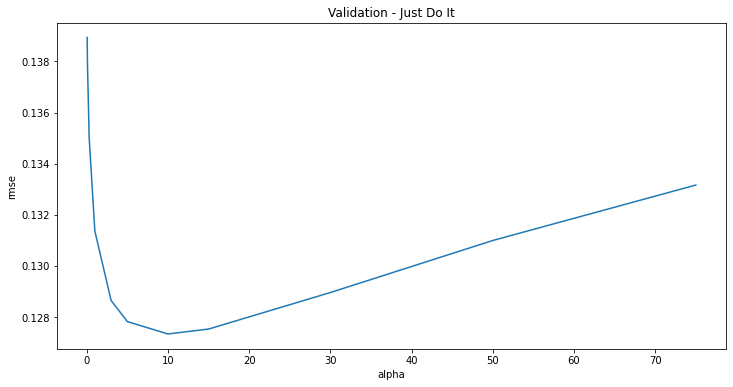

In [20]:
cv_ridge=pd.Series(cv_ridge, index=alphas)
cv_ridge.plot(title='Validation - Just Do It')
plt.xlabel('alpha')
plt.ylabel('rmse')

* alpha값이 일정값에 다다를때까진 rmse값이 작아지다가, 다시 올라가는 형태
* alpha값이 너무 커지면 규제가 너무 강해져서 모델이 데이터의 모든 복잡성을 발견하기 어렵다. 
* 반면에 alpha가 너무 작으면 모델은 overfit된다.
    * 위 plot을 보았을때, alpha=10이 가장 적절하다.

In [21]:
# 릿지모델에서 가장작은 rmse값은아래와같다.
# 0.127
cv_ridge.min()

0.12733734668670774

### (2) Lasso Model
* 라쏘 모델로 feature selection도 가능.(계수확인)

In [22]:
# Lasso는 cross-val 안함.
model_lasso=LassoCV(alphas=[1, 0.1, 0.001, 0.0005]).fit(X_train,y)

In [23]:
# 0.1225 로 Lasso모델이 Ridge모델보다 rmse평균값이 적게나옴. good!
rmse_cv(model_lasso).mean()

0.12256735885048124

In [24]:
# 라쏘모델에서의 각 feature별 계수
coef=pd.Series(model_lasso.coef_, index=X_train.columns)
coef

MSSubClass              -0.007480
LotFrontage              0.000000
LotArea                  0.071826
OverallQual              0.053160
OverallCond              0.043027
                           ...   
SaleCondition_AdjLand    0.000000
SaleCondition_Alloca    -0.000000
SaleCondition_Family    -0.007925
SaleCondition_Normal     0.019666
SaleCondition_Partial    0.000000
Length: 288, dtype: float64

In [25]:
# 110개의 feature를 선택하고 178개 제거
print('Lasso picked' + str(sum(coef!=0)) + "variables and eliminatied the other"+str(sum(coef==0))+'variables')

Lasso picked110variables and eliminatied the other178variables


* 데이터에 다중공선성이 많으면, 선택된 Feature들이 정확한것은 아니다. 
* 여기서 해볼수있는 것은 Lasso를 boostrapped 로 몇번 돌려보고 feature selection이 얼마나 안정적인지 (동일한 feature가 계속 feature로 선택되는지) 를 살펴본다.

In [26]:
# 중요한 coefficient확인
imp_coef=pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
imp_coef

RoofMatl_ClyTile        -0.704161
MSZoning_C (all)        -0.292023
Condition2_PosN         -0.190552
Neighborhood_Edwards    -0.052560
SaleCondition_Abnorml   -0.047116
MSZoning_RM             -0.037698
CentralAir_N            -0.035440
GarageCond_Fa           -0.031688
LandContour_Bnk         -0.030934
SaleType_WD             -0.030656
OverallQual              0.053160
KitchenQual_Ex           0.063709
Exterior1st_BrkFace      0.070464
Neighborhood_NridgHt     0.071620
LotArea                  0.071826
Functional_Typ           0.072597
Neighborhood_NoRidge     0.085717
Neighborhood_Crawfor     0.105138
Neighborhood_StoneBr     0.112493
GrLivArea                0.400009
dtype: float64

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

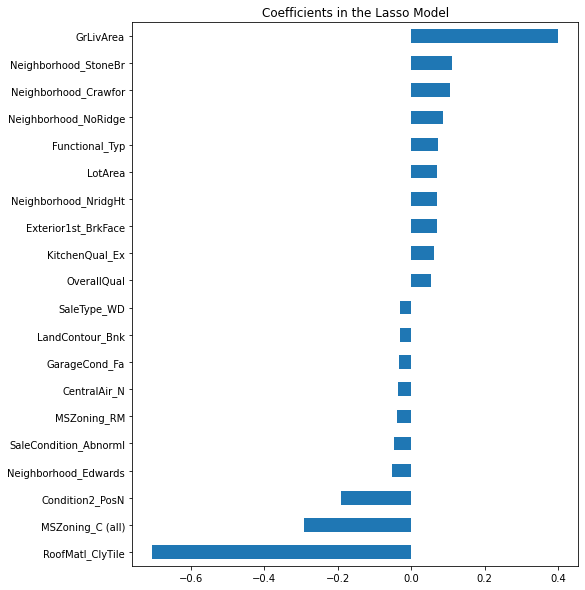

In [27]:
matplotlib.rcParams['figure.figsize']=(8.0, 10.0)
imp_coef.plot(kind='barh')
plt.title('Coefficients in the Lasso Model')

* GrLivArea가 가장 중요한 변수로 나옴. (=> the above ground area by area square feet. )
* 몇몇의 negative features들은 좀더 볼 가치가있어보인다. 
    * unbalanced categorical variables 에서 나온것으로 보임.
    
* 여기서 이슈는, 우리가 target변수 (SalePrice)와 수치형 변수 모두 로그변환을 해주어서 실제 단위를 해석하기어렵다.

**잔차 확인**

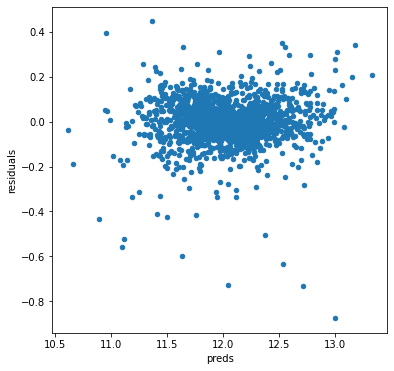

In [28]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

# 예측값과 실제y값
preds=pd.DataFrame({'preds':model_lasso.predict(X_train), 'true':y})
# 잔차 = 실제값 - 예측값
preds['residuals']=preds['true']-preds['preds']
preds.plot(x='preds', y='residuals',kind='scatter');

* 잔차가 패턴없이 잘 흩어져있는것으로 보임. good!
* 이제 test set으로 예측한 결과를 submit해서 리더보드에 올리기

### (3) Adding an xgboost model
* install error

In [29]:
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
conda list anaconda

In [ ]:
from platform import python_version
print(python_version())

In [ ]:
!pip install xgboost

In [ ]:
!pip install cmake

In [ ]:
conda remove xgboost

In [ ]:
# 0.7 버전으로다시설치해보기
conda install -c aterrel xgboost=0.4.0

In [ ]:
conda install -c conda-forge xgboost

In [ ]:
import sys
print(sys.base_prefix)

In [ ]:
import sys
!{sys.executable} -m pip install xgboost

------------------------------------------------------------------
> xgboost install error로 인해 kaggle notebook에서 작업

### (3)Adding an xgboost model
* DMatrix
    * XGBoost에서 사용되는 데이터 구조이다.
* 최적의 파라미터를 찾기위해 xgb.cv를 사용함.

In [24]:
import xgboost as xgb

In [25]:
dtrain=xgb.DMatrix(X_train,label=y)
dtest=xgb.DMatrix(X_test)

params={'max_depth':2,"eta":0.1}
model=xgb.cv(params, dtrain,num_boost_round=500,early_stopping_rounds=100)

In [26]:
model

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,10.380516,0.003151,10.380511,0.007227
1,9.345150,0.002914,9.345143,0.007585
2,8.413392,0.002711,8.413386,0.007926
3,7.574889,0.002511,7.575220,0.007951
4,6.820173,0.002320,6.820488,0.007688
...,...,...,...,...
495,0.062966,0.002789,0.123259,0.011761
496,0.062934,0.002776,0.123262,0.011772
497,0.062853,0.002779,0.123252,0.011764
498,0.062776,0.002763,0.123265,0.011827


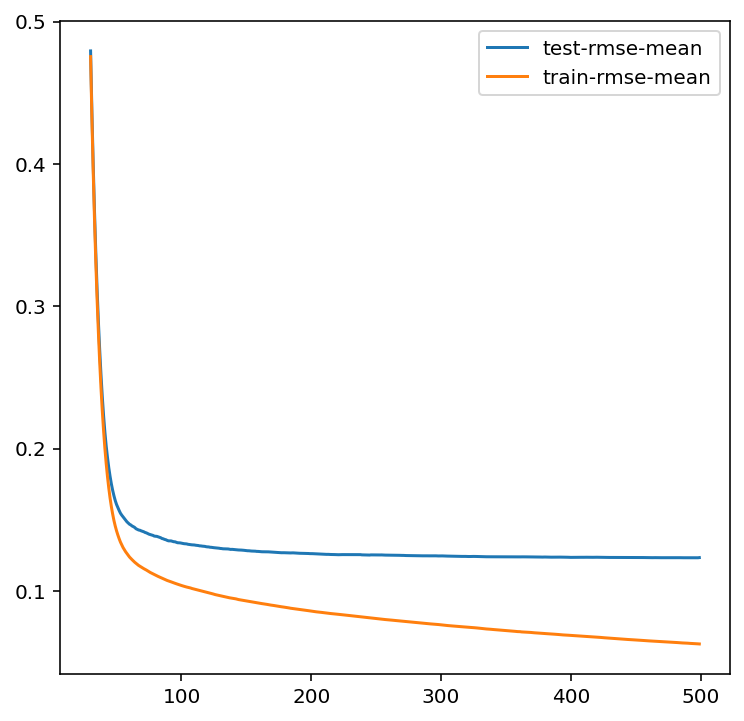

In [27]:
model.loc[30:,['test-rmse-mean','train-rmse-mean']].plot()

In [34]:
model_xgb=xgb.XGBRegressor(n_estimators=360, max_depth=2,learning_rate=0.1)
#the params were tuned using xgb.cv
model_xgb.fit(X_train,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=360, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [36]:
# 로그변환 되어있는 값을 다시 지수로바꿔주는건가.
xgb_preds=np.expm1(model_xgb.predict(X_test))
xgb_preds

array([120528.96, 156569.97, 186196.9 , ..., 156040.19, 119248.19,
       226422.4 ], dtype=float32)

In [37]:
model_xgb.predict(X_test)

array([11.699654, 11.961265, 12.134565, ..., 11.957875, 11.688971,
       12.330162], dtype=float32)

In [39]:
# np.expm1 : 다시 지수변환.
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

In [45]:
# 모델평가
## Ridge보단 좋고, Lasso보단 안좋게나옴.
rmse_cv(model_xgb).mean()

0.12494475766362181

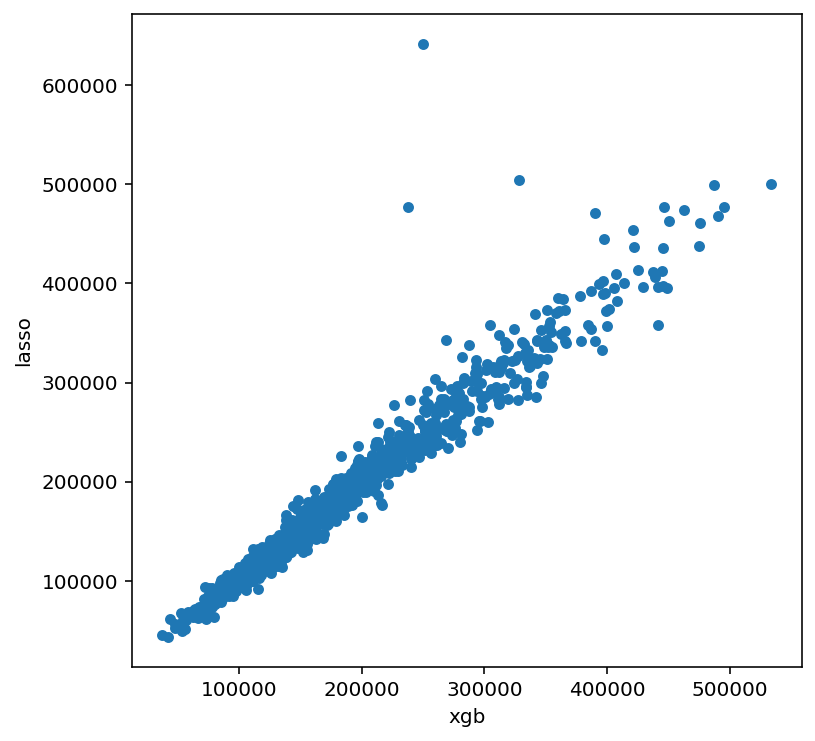

In [40]:
predictions=pd.DataFrame({'xgb':xgb_preds,'lasso': lasso_preds})
predictions.plot(x='xgb',y='lasso',kind='scatter');

In [41]:
predictions

,xgb,lasso
0,120528.960938,119958.035681
1,156569.968750,151482.567322
2,186196.906250,180200.853648
3,192304.500000,197515.619193
4,185913.000000,202434.157491
...,...,...
1454,82824.835938,89498.417853
1455,83267.796875,85791.775966
1456,156040.187500,169023.548082
1457,119248.187500,118942.417687


In [42]:
preds=0.7*lasso_preds + 0.3*xgb_preds

In [43]:
preds

array([120129.31638285, 153008.78931275, 181999.67177217, ...,
       165128.54225094, 119034.14941217, 227808.93476155])

In [44]:
solution=pd.DataFrame({'id':test.Id,'SalePrice':preds})
solution.to_csv('ridge_sol.csv', index=False)

## 결과
* Ridge-rmse-mean
    * 0.13136184989399582
* Lasso-rmse-mean
    * 0.12256735885048124
* xgboost-rmse-mean
    * 0.12494475766362181
    
> Lasso 모델이 가장 적절한것으로 판단